<a href="https://www.kaggle.com/code/hossamadel/fork-of-football-events-hossam-adel?scriptVersionId=105193906" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/football-events/ginf.csv
/kaggle/input/football-events/dictionary.txt
/kaggle/input/football-events/events.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import average_precision_score, roc_auc_score, f1_score, precision_score, \
recall_score, cohen_kappa_score, classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler
pd.options.display.max_columns = 999
pd.options.display.max_rows = 50

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

## LOAD AND EXTRACT THE DATA

In [3]:
events = pd.read_csv('/kaggle/input/football-events/events.csv')
info = pd.read_csv('/kaggle/input/football-events/ginf.csv')

In [4]:
# We add to our events dataset useful information from the ginf.csv, such as the league/country and the date

events = events.merge(info[['id_odsp', 'country', 'date']], on='id_odsp', how='left')
extract_year = lambda x: datetime.strptime(x, "%Y-%m-%d").year
events['year'] = [extract_year(x) for key, x in enumerate(events['date'])]

In [5]:
# We create a new dataset named Shots that will contain everything related to this action of the game and exclude the rest.

shots = events[events.event_type==1]
shots['player'] = shots['player'].str.title()
shots['player2'] = shots['player2'].str.title()
shots['country'] = shots['country'].str.title()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

In [6]:
events.head(10)

,id_odsp,id_event,sort_order,time,text,event_type,event_type2,side,event_team,opponent,player,player2,player_in,player_out,shot_place,shot_outcome,is_goal,location,bodypart,assist_method,situation,fast_break,country,date,year
0,UFot0hit/,UFot0hit1,1,2,Attempt missed. Mladen Petric (Hamburg) left f...,1,12.0,2,Hamburg SV,Borussia Dortmund,mladen petric,gokhan tore,NaN,NaN,6.0,2.0,0,9.0,2.0,1,1.0,0,germany,2011-08-05,2011
1,UFot0hit/,UFot0hit2,2,4,"Corner, Borussia Dortmund. Conceded by Dennis...",2,NaN,1,Borussia Dortmund,Hamburg SV,dennis diekmeier,dennis diekmeier,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0,germany,2011-08-05,2011
2,UFot0hit/,UFot0hit3,3,4,"Corner, Borussia Dortmund. Conceded by Heiko ...",2,NaN,1,Borussia Dortmund,Hamburg SV,heiko westermann,heiko westermann,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0,germany,2011-08-05,2011
3,UFot0hit/,UFot0hit4,4,7,Foul by Sven Bender (Borussia Dortmund).,3,NaN,1,Borussia Dortmund,Hamburg SV,sven bender,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0,germany,2011-08-05,2011
4,UFot0hit/,UFot0hit5,5,7,Gokhan Tore (Hamburg) wins a free kick in the ...,8,NaN,2,Hamburg SV,Borussia Dortmund,gokhan tore,NaN,NaN,NaN,NaN,NaN,0,2.0,NaN,0,NaN,0,germany,2011-08-05,2011
5,UFot0hit/,UFot0hit6,6,9,Hand ball by Jose Paolo Guerrero (Hamburg).,10,NaN,2,Hamburg SV,Borussia Dortmund,jose paolo guerrero,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0,germany,2011-08-05,2011
6,UFot0hit/,UFot0hit7,7,10,"Corner, Hamburg. Conceded by Lukasz Piszczek.",2,NaN,2,Hamburg SV,Borussia Dortmund,lukasz piszczek,lukasz piszczek,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0,germany,2011-08-05,2011
7,UFot0hit/,UFot0hit8,8,11,Chris Lowe (Borussia Dortmund) wins a free kic...,8,NaN,1,Borussia Dortmund,Hamburg SV,chris lowe,NaN,NaN,NaN,NaN,NaN,0,2.0,NaN,0,NaN,0,germany,2011-08-05,2011
8,UFot0hit/,UFot0hit9,9,11,Foul by Gojko Kacar (Hamburg).,3,NaN,2,Hamburg SV,Borussia Dortmund,gojko kacar,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0,germany,2011-08-05,2011
9,UFot0hit/,UFot0hit10,10,13,Foul by Gokhan Tore (Hamburg).,3,NaN,2,Hamburg SV,Borussia Dortmund,gokhan tore,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0,germany,2011-08-05,2011


In [7]:
events.shape

(941009, 25)

In [8]:
info.head(10)

,id_odsp,link_odsp,adv_stats,date,league,season,country,ht,at,fthg,ftag,odd_h,odd_d,odd_a,odd_over,odd_under,odd_bts,odd_bts_n
0,UFot0hit/,/soccer/germany/bundesliga-2011-2012/dortmund-...,True,2011-08-05,D1,2012,germany,Borussia Dortmund,Hamburg SV,3,1,1.56,4.41,7.42,NaN,NaN,NaN,NaN
1,Aw5DflLH/,/soccer/germany/bundesliga-2011-2012/augsburg-...,True,2011-08-06,D1,2012,germany,FC Augsburg,SC Freiburg,2,2,2.36,3.60,3.40,NaN,NaN,NaN,NaN
2,bkjpaC6n/,/soccer/germany/bundesliga-2011-2012/werder-br...,True,2011-08-06,D1,2012,germany,Werder Bremen,Kaiserslautern,2,0,1.83,4.20,4.80,NaN,NaN,NaN,NaN
3,CzPV312a/,/soccer/france/ligue-1-2011-2012/paris-sg-lori...,True,2011-08-06,F1,2012,france,Paris Saint-Germain,Lorient,0,1,1.55,4.50,9.40,NaN,NaN,NaN,NaN
4,GUOdmtII/,/soccer/france/ligue-1-2011-2012/caen-valencie...,True,2011-08-06,F1,2012,france,Caen,Valenciennes,1,0,2.50,3.40,3.45,NaN,NaN,NaN,NaN
5,lOpzwMkp/,/soccer/germany/bundesliga-2011-2012/hertha-be...,True,2011-08-06,D1,2012,germany,Hertha Berlin,Nurnberg,0,1,2.06,3.75,3.95,NaN,NaN,NaN,NaN
6,M7PhlM2C/,/soccer/france/ligue-1-2011-2012/brest-evian-t...,True,2011-08-06,F1,2012,france,Brest,Evian Thonon Gaillard,2,2,2.29,3.25,3.85,NaN,NaN,NaN,NaN
7,QuWqjrYa/,/soccer/france/ligue-1-2011-2012/ac-ajaccio-to...,True,2011-08-06,F1,2012,france,AC Ajaccio,Toulouse,0,2,2.80,3.10,3.05,NaN,NaN,NaN,NaN
8,UBZQ4smg/,/soccer/france/ligue-1-2011-2012/nice-lyon-UBZ...,True,2011-08-06,F1,2012,france,Nice,Lyon,1,3,4.50,3.55,2.00,NaN,NaN,NaN,NaN
9,Wn69eU5B/,/soccer/germany/bundesliga-2011-2012/koln-wolf...,True,2011-08-06,D1,2012,germany,FC Cologne,VfL Wolfsburg,0,3,3.00,3.80,2.54,NaN,NaN,NaN,NaN


In [9]:
info.shape

(10112, 18)

## DATA EXPLORATION

In [10]:
pie = shots[['shot_outcome', 'id_event']].groupby('shot_outcome').count().reset_index().rename(columns={'id_event': 'count'})

In [11]:
pie.shot_outcome = pie.shot_outcome.astype(int)
pie.shot_outcome = pie.shot_outcome.replace({1: 'On Target', 2: 'Off Target', 3: 'Blocked', 4: 'Hit the Bar'})

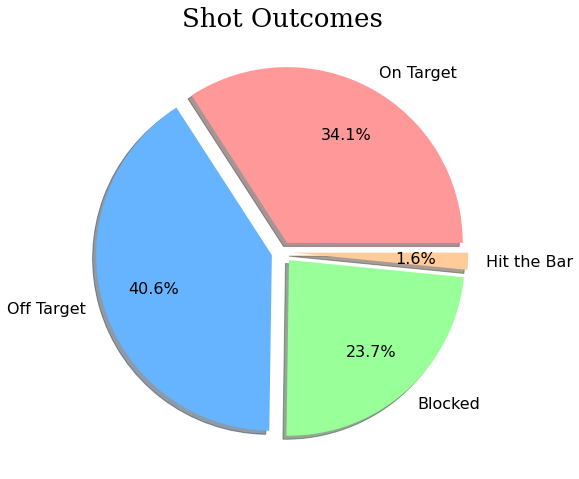

In [12]:
fig, ax = plt.subplots(figsize=[8,8])
labels = pie['shot_outcome']
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
plt.pie(x=pie['count'], autopct="%.1f%%", labels=labels, explode=[0.06]*4, pctdistance=0.7, colors=colors, shadow=True, \
       textprops=dict(fontsize=16))
plt.title("Shot Outcomes", fontsize=26, fontfamily='serif')
plt.tight_layout()
plt.show()

In [13]:
bar = shots[['shot_place', 'id_event']].groupby('shot_place').count().reset_index().rename(columns={'id_event': 'count'})

bar.shot_place = bar.shot_place.astype(int)

bar.shot_place = bar.shot_place.replace({1: 'Bit too high', 2: 'Blocked', 3: 'Bottom left corner', 4: 'Bottom right corner', \
                                        5: 'Centre of the goal', 6: 'High and wide', 7: 'Hits the bar', 8: 'Misses to the left', \
                                        9: 'Misses to the right', 10: 'Too high', 11: 'Top centre of the goal', \
                                        12: 'Top left corner', 13: 'Top right corner'})

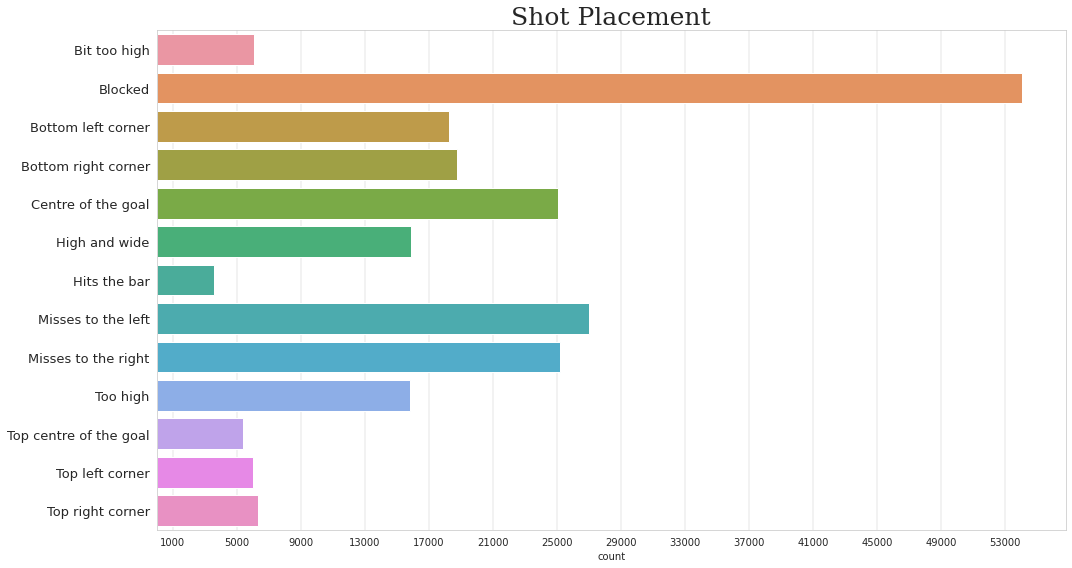

In [14]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=[15,8])
labels = bar['shot_place']
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
ax = sns.barplot(x=bar['count'], y=labels)
ax.set_yticklabels(labels, size = 13)
ax.set_xticks(np.arange(1000,57000,4000))
ax.set_ylabel(ylabel='')
plt.title("Shot Placement", fontsize=25, fontfamily='serif')
plt.tight_layout()
ax.grid(color='black', linestyle='-', linewidth=0.1, axis='x')
plt.show()

### we see that the majority are either directed at the centre of the goal, or miss to the left or right side.

In [15]:
# We'll explore something that will be important for our xG model: which percentage of shots end up as goals. We'll divide this analysis for the different leagues and across years, to check if there are differences in the patterns through different parts of the world or different years.

goals  = shots[['is_goal', 'id_event', 'country']].groupby(['is_goal', 'country']).count().reset_index().rename(columns={'id_event': 'count'})
goals.is_goal = goals.is_goal.replace({1: 'Goal', 0: 'No Goal'})

In [16]:
goals['percentage']=0
for i in range(len(goals)):
    for country in goals.country.unique():
        if goals.iloc[i,goals.columns.get_loc("country")]==country:
            goals.iloc[i,goals.columns.get_loc("percentage")]=goals.iloc[i,goals.columns.get_loc("count")] / \
                                                            goals[goals.country==country]['count'].sum()
goals['percentage']=round(goals['percentage']*100,2)

In [17]:
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.2f}%'.format(p.get_height())
            ax.text(_x, _y+2, value, ha="center", fontsize=14) 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

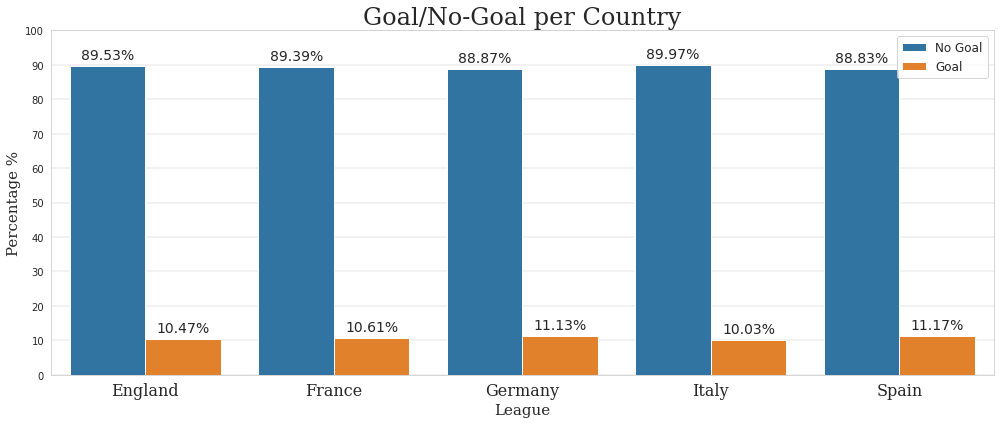

In [18]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=[14,6])
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
ax = sns.barplot(data=goals, y='percentage', hue='is_goal', x='country')
ax.set_yticks(np.arange(0,110,10))
ax.set_ylabel(ylabel='Percentage %', fontsize=15, fontfamily='serif')
ax.set_xlabel(xlabel='League', fontsize=15, fontfamily='serif')
ax.set_xticklabels(labels=ax.get_xticklabels(), fontsize=16, fontfamily='serif')
plt.title("Goal/No-Goal per Country", fontsize=24, fontfamily='serif')
plt.tight_layout()
ax.grid(color='black', linestyle='-', linewidth=0.1, axis='y')
plt.legend(fontsize=12)
show_values_on_bars(ax)
plt.show()

In [19]:
goals  = shots[['is_goal', 'id_event', 'year']].groupby(['is_goal', 'year']).count().reset_index().rename(columns={'id_event': 'count'})
goals.is_goal = goals.is_goal.replace({1: 'Goal', 0: 'No Goal'})

In [20]:
goals['percentage']=0
for i in range(len(goals)):
    for year in goals.year.unique():
        if goals.iloc[i,goals.columns.get_loc("year")]==year:
            goals.iloc[i,goals.columns.get_loc("percentage")]=goals.iloc[i,goals.columns.get_loc("count")] / \
                                                            goals[goals.year==year]['count'].sum()
goals['percentage']=round(goals['percentage']*100,2)

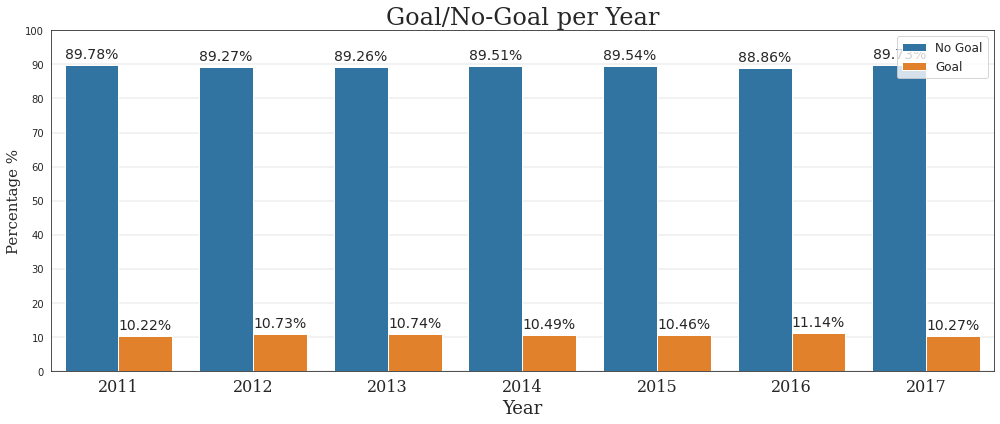

In [21]:
sns.set_style("white")
fig, ax = plt.subplots(figsize=[14,6])
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
ax = sns.barplot(data=goals, y='percentage', hue='is_goal', x='year')
ax.set_yticks(np.arange(0,110,10))
ax.set_ylabel(ylabel='Percentage %', fontsize=15, fontfamily='serif')
ax.set_xlabel(xlabel='Year', fontsize=18, fontfamily='serif')
ax.set_xticklabels(labels=ax.get_xticklabels(), fontsize=16, fontfamily='serif')
plt.title("Goal/No-Goal per Year", fontsize=24, fontfamily='serif')
plt.tight_layout()
ax.grid(color='black', linestyle='-', linewidth=0.1, axis='y')
plt.legend(fontsize=12)
show_values_on_bars(ax)
plt.show()

## xG Model

##### After this (long) introduction, let's prepare X and Y sets. Y will simply include every shot in the database and whether it was a goal or not (1 or 0). It is our target variable. X will include all the relevant information about the shot that we have in our data. That would be:

##### . **location:** attacking half, defensive half, centre of the box, left wing, right wing, difficult angle and long range, difficult angle on the left, difficult angle on the right, left side of the box, left side of the six yard box, right side of the box, right side of the six yard box, very close range, penalty spot, outside the box, long range, more than 35 yards, more than 40 yards, not recorded.

##### .**bodypart:** right foot, left foot, head.

##### . **assist_method:** none, pass, cross, headed pass, through ball.

##### . **situation:** open play, set piece, corner, free kick.

##### . **fast_break:** 1 or 0, whether the shot comes from a fast break or not.

##### So, we have a lot of meaningful information about every shot. The location from which it was taken, which part of the body was used for shooting, how the shoot was made available (after a pass? a cross? etc.), and the situation or context in which the shoot occured (open play, corner, etc.) 

In [22]:
# we have to convert them to binary dummies (except for fast_break, which is already binary)

data = pd.get_dummies(shots.iloc[:,-8:-3], columns=['location', 'bodypart','assist_method', 'situation'])
data.columns = ['fast_break', 'loc_centre_box', 'loc_diff_angle_lr', 'diff_angle_left', 'diff_angle_right',
                'left_side_box', 'left_side_6ybox', 'right_side_box', 'right_side_6ybox', 'close_range',
                'penalty', 'outside_box', 'long_range', 'more_35y', 'more_40y', 'not_recorded', 'right_foot', 
                'left_foot', 'header', 'no_assist', 'assist_pass', 'assist_cross', 'assist_header',
                'assist_through_ball', 'open_play', 'set_piece', 'corner', 'free_kick']
data['is_goal'] = shots['is_goal']

In [23]:
print(len(data))
print(data.is_goal.sum())
print(len(data.columns)-1)

229135
24441
28


##### So we have a total of 229,135 shots, of which 24,441 were goals. For each shot, we have 28 different characteristics that describe it. All of these 28 characteristics are binary, so they just indicate Yes or No to a certain characteristics in the shot.

##### Now we will divide our X and y into two different sets for training and testing. I will use 65% of them for training our model and 35% por testing it. This is because we have enough datapoints, so 65% should be enough to train it properly and I'd rather have as many shots left as possible for pure testing later.

## Split Data

In [24]:
X = data.iloc[:,:-1]
y = data.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=1)

## Gradient Boosting Classifier(Hyperopt)

In [25]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

def evaluate_model(params): 
    model = GradientBoostingClassifier(
                        learning_rate=params['learning_rate'],
                        min_samples_leaf=params['min_samples_leaf'],
                        max_depth = params['max_depth'],
                        max_features = params['max_features']
                        )

    model.fit(X_train, y_train)
    return {
        'learning_rate': params['learning_rate'],
        'min_samples_leaf': params['min_samples_leaf'],
        'max_depth': params['max_depth'],
        'max_features': params['max_features'],
        'train_ROCAUC': roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]),
        'test_ROCAUC': roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]),
        'recall': recall_score(y_test, model.predict(X_test)),
        'precision': precision_score(y_test, model.predict(X_test)),
        'f1_score': f1_score(y_test, model.predict(X_test)),
        'train_accuracy': model.score(X_train, y_train),
        'test_accuracy': model.score(X_test, y_test),
    }



def objective(params):
    res = evaluate_model(params)
    
    res['loss'] = - res['test_ROCAUC'] # Esta loss es la que hyperopt intenta minimizar
    res['status'] = STATUS_OK # Asi le decimos a hyperopt que el experimento salio bien
    return res 

hyperparameter_space = {
        'learning_rate': hp.uniform('learning_rate', 0.05, 0.3),
        'min_samples_leaf': hp.choice('min_samples_leaf', range(15, 200)),
        'max_depth': hp.choice('max_depth', range(2, 20)),
        'max_features': hp.choice('max_features', range(3, 27))
}

In [26]:
trials = Trials()
fmin(
    objective,
    space=hyperparameter_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials
);

100%|██████████| 50/50 [13:22<00:00, 16.06s/trial, best loss: -0.8194258348582499]


In [27]:
pd.DataFrame(trials.results).sort_values(by='f1_score', ascending=False).head()

,learning_rate,min_samples_leaf,max_depth,max_features,train_ROCAUC,test_ROCAUC,recall,precision,f1_score,train_accuracy,test_accuracy,loss,status
7,0.273306,49,12,24,0.819150,0.818177,0.268697,0.711616,0.390098,0.910600,0.910908,-0.818177,ok
10,0.255877,110,19,18,0.818955,0.818510,0.268462,0.711880,0.389890,0.910566,0.910908,-0.818510,ok
3,0.191183,33,5,26,0.818226,0.819114,0.267874,0.715677,0.389835,0.910512,0.911083,-0.819114,ok
1,0.071018,133,5,21,0.816449,0.818722,0.267521,0.717439,0.389722,0.910385,0.911157,-0.818722,ok
24,0.083598,137,8,7,0.817480,0.819416,0.267286,0.717035,0.389412,0.910351,0.911120,-0.819416,ok


In [28]:
model = GradientBoostingClassifier(
                        learning_rate=0.285508,
                        min_samples_leaf=99,
                        max_depth = 19,
                        max_features = 7
                        )
model.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.285508, max_depth=19, max_features=7,
                           min_samples_leaf=99)

In [29]:
print('The test set contains {} examples (shots) of which {} are positive (goals).'.format(len(y_test), y_test.sum()))
print('The accuracy of classifying whether a shot is goal or not is {}%.'.format(round(model.score(X_test, y_test)*100),2))
print('Our classifier obtains an ROC-AUC of {}%'.format(round(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])*100),2))

The test set contains 80198 examples (shots) of which 8504 are positive (goals).
The accuracy of classifying whether a shot is goal or not is 91%.
Our classifier obtains an ROC-AUC of 82%


##### So, we can see that our **xG** model is able to correctly predict whether a shot is goal or not **91%** of the times. 
##### Furthermore, we obtain a pretty good **ROC-AUC** metric of **82%**. This looks very promising.

##### Now we'll explore **PR-AUC **(Precision-Recall Under the Curve), and **Cohen's Kappa** statistic. Both of these are more appropiate for our case, since they do take into account the imbalance in our data.

In [30]:
print('The baseline performance for PR-AUC is {}%. This is the PR-AUC that what we would get by random guessing.'.format(round(y_train.mean(),2)))
print('Our model obtains an PR-AUC of {}%.'.format(round(average_precision_score(y_test, model.predict_proba(X_test)[:, 1])*100,2)))
print('Our classifier obtains a Cohen Kappa of {}.'.format(round(cohen_kappa_score(y_test,model.predict(X_test)),2)))

The baseline performance for PR-AUC is 0.11%. This is the PR-AUC that what we would get by random guessing.
Our model obtains an PR-AUC of 47.36%.
Our classifier obtains a Cohen Kappa of 0.35.


In [31]:
print(color.BOLD + color.YELLOW + 'Confusion Matrix:\n' + color.END)
print(confusion_matrix(y_test,model.predict(X_test)))
print(color.BOLD +  color.YELLOW + '\n Report:' + color.END)
print(classification_report(y_test,model.predict(X_test)))

Confusion Matrix:

[[70787   907]
 [ 6227  2277]]

 Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     71694
           1       0.72      0.27      0.39      8504

    accuracy                           0.91     80198
   macro avg       0.82      0.63      0.67     80198
weighted avg       0.90      0.91      0.89     80198



##### The confusion matrix summarizes all predictions. It tells us that, from all the shots that were not goal, our model correctly identified **70,781** as no-goals, and made a mistake in **6,238** cases in which it predicted that the shot would not be a goal, but it was. From the other column, we see that it correctly predicted 913 goals, but failed to predict 2266 succesful shots as goals.

##### From the report we can see the model has excellent numbers when it comes to predict class 0 (no-goal), but not that good for predicting class 1 (goals). With the latter, we have a precision of **71%**, and a recall of **27%**, resulting in an F1 score of 0.39. These are decent numbers, but not really good.

##### Does this make sense? Of course it does. Predicting whether a shot will be goal and being right is extremely more difficult than correctly predicting it will not be a goal

## Logistic Regression

In [32]:
model = LogisticRegression(max_iter=400)
model.fit(X_train, y_train)

LogisticRegression(max_iter=400)

In [33]:
print('The test set contains {} examples (shots) of which {} are positive (goals).'.format(len(y_test), y_test.sum()))
print('The accuracy of classifying whether a shot is goal or not is {}%.'.format(round(model.score(X_test, y_test)*100),2))
print('Our classifier obtains an ROC-AUC of {}%'.format(round(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])*100),2))

The test set contains 80198 examples (shots) of which 8504 are positive (goals).
The accuracy of classifying whether a shot is goal or not is 91%.
Our classifier obtains an ROC-AUC of 82%


In [34]:
print('The baseline performance for PR-AUC is {}%. This is the PR-AUC that what we would get by random guessing.'.format(round(y_train.mean(),2)))
print('Our model obtains an PR-AUC of {}%.'.format(round(average_precision_score(y_test, model.predict_proba(X_test)[:, 1])*100,2)))
print('Our classifier obtains a Cohen Kappa of {}.'.format(round(cohen_kappa_score(y_test,model.predict(X_test)),2)))

The baseline performance for PR-AUC is 0.11%. This is the PR-AUC that what we would get by random guessing.
Our model obtains an PR-AUC of 47.08%.
Our classifier obtains a Cohen Kappa of 0.35.


In [35]:
print(color.BOLD + color.YELLOW + color.UNDERLINE + 'Confusion Matrix:\n' + color.END)
print(confusion_matrix(y_test,model.predict(X_test)))
print(color.BOLD +  color.YELLOW + color.UNDERLINE + '\n Report:' + color.END)
print(classification_report(y_test,model.predict(X_test)))

Confusion Matrix:

[[70820   874]
 [ 6265  2239]]

 Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     71694
           1       0.72      0.26      0.39      8504

    accuracy                           0.91     80198
   macro avg       0.82      0.63      0.67     80198
weighted avg       0.90      0.91      0.89     80198



In [36]:
model = GradientBoostingClassifier(
                        learning_rate=0.285508,
                        min_samples_leaf=99,
                        max_depth = 19,
                        max_features = 7
                        )
model.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.285508, max_depth=19, max_features=7,
                           min_samples_leaf=99)

### Feature Importances

In [37]:
import eli5
eli5.explain_weights(model, feature_names=list(X_train.columns))

Weight,Feature
0.1809 ± 0.1621,close_range
0.1772 ± 0.0804,not_recorded
0.1731 ± 0.0773,penalty
0.1671 ± 0.1059,outside_box
0.0566 ± 0.1690,fast_break
0.0427 ± 0.1366,loc_centre_box
0.0302 ± 0.1405,assist_cross
0.0261 ± 0.0544,assist_through_ball
0.0243 ± 0.1309,header
0.0225 ± 0.0622,open_play


This makes things easier for the model. To better understand the model, it could be interesting to remove those rows and check its performance. I have tried it and it results in a slight decrease in performance **(ROC-AUC=0.806, PR-AUC = 0.41)**, so no too large differences. I will leave these rows anyway, as I will do players' analyses later and I don't want valuable information about the goals of the players being erased.

## 3. Conclusions about xG Model

### 3.a) How good is our model?

It is hard to determine whether the model is good, as there is not much to compare with. I think that Cohen's Kappa and PR-AUC PR are the best indicators we have to measure its performance, but it's not easy to find these numbers for other different **xG** models for comparison. Many report the aggregated R2 by season, but that does not make a lot of sense. In Section 4 we will see that our model results in a correlation of **0.97** between the total expected goals and the actual goals by player, suggesting that the model may be sufficiently good, but this measure is also not ideal.

So then we can compare this model with others, at least on this statistic, which as I have mentioned before I don't think is the best one to determine how well the model performs.

Our model has a **ROC-AUC** of **81.9%**, suggesting it is pretty decent, at least compared to those.

### 3.b) How could we improve our xG model?

I've tried different algorithms with different hyperparameters and the results did not change much.

But, what additional data could we add to improve our model? First, it would be great to have information about the defending team. How many defenders are between the goal and the player with the ball? How much defensive pressure is the shooting player withstanding? How much time/space does the player have in order to shoot? I imagine the (quantified) answers to many of these questions could give the model interesting new information to base its predictions on.

Additionally, we have the location of the shot divided in 17 different categories. This is good, but it could be better to have exact x and y coordinates of where the player is. This could lead to more precision in the location of each shot, and therefore in the predictions of the model.

## 4. Player Analysis

We'll start by adding the information we have about expected goals to each shot in our original data. From there, we can extract many interesting metrics about players, all of these metrics being related in one way or another to the new xG predictions for each shot.

In [38]:
shots['prediction'] = model.predict_proba(X)[:, 1]
shots['difference'] = shots['prediction'] - shots['is_goal']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### 4.a) Which players are the best finishers?

By looking at the difference between a player's number of goals and his number of expected goals, we can see who are the best at finishing plays. We can approach this problem from two different points of view:

1- Look at the difference between total goals scored and total expected goals: This will tell us which player scored the highest number of goals compared to what he was expected to score.

2- Look at the ratio between total goals scored and total expected goals: This will tell us precisely the relation of how many goals the player actually scores for each goal he was supposed to score.

In [39]:
players = shots.groupby('player').sum().reset_index()
players.rename(columns={'is_goal': 'trueGoals', 'prediction': 'expectedGoals'}, inplace=True)
players.expectedGoals = round(players.expectedGoals,2)
players.difference = round(players.difference,2)
players['ratio'] = players['trueGoals'] / players['expectedGoals']

In [40]:
print(round(players.expectedGoals.corr(players.trueGoals),3))

0.977


### Best Finishers

In [41]:
show = players.sort_values(['difference', 'trueGoals']).reset_index(drop=True)
show['rank'] = show.index+1
show = show[['rank', 'player', 'difference', 'trueGoals', 'expectedGoals']].head(10)
show.head(5)

,rank,player,difference,trueGoals,expectedGoals
0,1,Lionel Messi,-58.79,205,146.21
1,2,Zlatan Ibrahimovic,-33.77,153,119.23
2,3,Cristiano Ronaldo,-32.25,198,165.75
3,4,Gonzalo Higuain,-31.68,118,86.32
4,5,Luis Suarez,-31.67,96,64.33


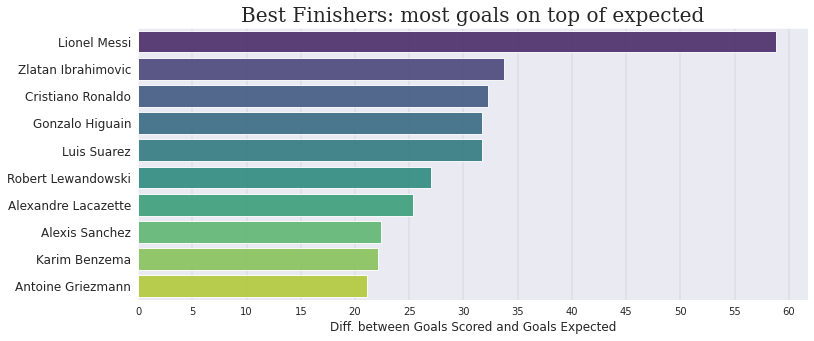

In [42]:
sns.set_style("dark")
fig, ax = plt.subplots(figsize=[12,5])
ax = sns.barplot(x=abs(show['difference']), y=show['player'], palette='viridis', alpha=0.9)
ax.set_xticks(np.arange(0,65,5))
ax.set_xlabel(xlabel='Diff. between Goals Scored and Goals Expected', fontsize=12)
ax.set_ylabel(ylabel='')
ax.set_yticklabels(labels=ax.get_yticklabels(), fontsize=12)
plt.title("Best Finishers: most goals on top of expected", fontsize=20, fontfamily='serif')
ax.grid(color='black', linestyle='-', linewidth=0.1, alpha=0.8, axis='x')
plt.show()

Not surprisingly, we can see that **Messi** is much better than everyone else on this metric.

Let's see what happens when we look instead at the goalsScored / expectedGoals ratio. We'll keep only players who scored more than 30 goals in total (the data covers an 8-years span, so 30 goals is not much).

In [43]:
show = players[players['trueGoals']>30].sort_values(['ratio', 'trueGoals'], ascending=False).reset_index(drop=True)
show['rank'] = show.index+1
show = show[['rank', 'player', 'ratio', 'trueGoals', 'expectedGoals']].head(10)
show.head(10)

,rank,player,ratio,trueGoals,expectedGoals
0,1,Franck Ribery,1.900238,40,21.05
1,2,Mario Gotze,1.585261,37,23.34
2,3,Bas Dost,1.550388,36,23.22
3,4,Heungmin Son,1.520913,32,21.04
4,5,Carlos Tevez,1.493681,39,26.11
5,6,Luis Suarez,1.492305,96,64.33
6,7,Isco,1.453744,33,22.70
7,8,Alberto Bueno,1.444043,32,22.16
8,9,Eden Hazard,1.441860,62,43.00
9,10,Dries Mertens,1.429773,34,23.78


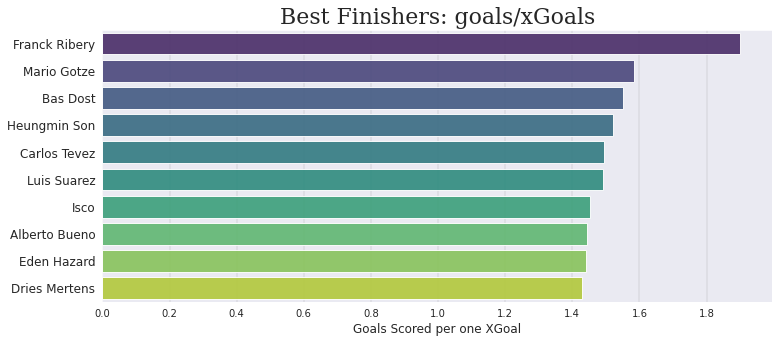

In [44]:
sns.set_style("dark")
fig, ax = plt.subplots(figsize=[12,5])
ax = sns.barplot(x=show['ratio'], y=show['player'], palette='viridis', alpha=0.9)
ax.set_xticks(np.arange(0,1.9,0.2))
ax.set_xlabel(xlabel='Goals Scored per one XGoal', fontsize=12)
ax.set_ylabel(ylabel='')
ax.set_yticklabels(labels=ax.get_yticklabels(), fontsize=12)
plt.title("Best Finishers: goals/xGoals", fontsize=22, fontfamily='serif')
ax.grid(color='black', linestyle='-', linewidth=0.1, axis='x')
plt.show()

### 4.b) Best Finishers per Year per League

In [45]:
players_per_year = shots.groupby(['year', 'country', 'player']).sum().reset_index()
players_per_year.rename(columns={'is_goal': 'trueGoals', 'prediction': 'expectedGoals'}, inplace=True)
players_per_year.expectedGoals = round(players_per_year.expectedGoals,2)
players_per_year.difference = round(players_per_year.difference,2)
players_per_year['ratio'] = players_per_year['trueGoals'] / players_per_year['expectedGoals']
players_per_year['ratio'] = round(players_per_year.ratio, 2)

In [46]:
def best_finishers_per_year(years, leagues, min_goals, df):
    years_res=[]; leagues_res=[]; players_res=[]; ratio_res=[]; goals=[]
    players_per_year = df[df['trueGoals']>min_goals]
    for league in leagues:
        for year in years:
            results = players_per_year[(players_per_year['year']==year) & (players_per_year['country']==league)].sort_values(by='ratio', ascending=False).reset_index(drop=True)
            results['rank'] = results.index + 1
            if len(results)>0:
                years_res.append(year)
                leagues_res.append(league)
                players_res.append(results[results['rank']==1]['player'].iloc[0])
                ratio_res.append(results[results['rank']==1]['ratio'].iloc[0])
                goals.append(results[results['rank']==1]['trueGoals'].iloc[0])
    return years_res, leagues_res, players_res, ratio_res, goals

In [47]:
years, leagues, players_res, ratio, goals = best_finishers_per_year(years = players_per_year.year.unique(), leagues=players_per_year.country.unique(),\
                       min_goals=12, df=players_per_year)

In [48]:
results_perYear = pd.DataFrame()
results_perYear['League']=leagues
results_perYear['Year']=years
results_perYear['bestFinisher']=players_res
results_perYear['Goals']=goals
results_perYear['Goals/xGoals Ratio']=ratio
results_perYear

,League,Year,bestFinisher,Goals,Goals/xGoals Ratio
0,France,2011,Olivier Giroud,13,1.24
1,France,2012,Zlatan Ibrahimovic,18,1.47
2,France,2013,Dario Cvitanich,16,1.69
3,France,2014,Cheick Diabate,13,1.61
4,France,2015,Benjamin Moukandjo,13,1.68
5,France,2016,Zlatan Ibrahimovic,21,2.26
6,Germany,2011,Klaasjan Huntelaar,15,1.82
7,Germany,2012,Martin Harnik,15,1.78
8,Germany,2013,Ivica Olic,13,2.22
9,Germany,2014,Josip Drmic,14,2.03


### 4.c) Worst finishers

In [49]:
show = players.sort_values(['difference', 'trueGoals']).reset_index(drop=True)
show['rank'] = show.index+1
show = show[['rank', 'player', 'difference', 'trueGoals', 'expectedGoals']].tail(10)
show.tail(5)

,rank,player,difference,trueGoals,expectedGoals
4782,4783,Adrian Mutu,8.59,17,25.59
4783,4784,Giampaolo Pazzini,8.68,31,39.68
4784,4785,Mats Hummels,8.94,10,18.94
4785,4786,Amauri,12.05,20,32.05
4786,4787,Jesus Navas,14.54,9,23.54


Let's see what happens when we look instead at the goalsScored / expectedGoals ratio. We'll keep only players who scored **more than 30** goals in total

In [50]:
show = players[players['trueGoals']>30].sort_values(['ratio', 'trueGoals'], ascending=False).reset_index(drop=True)
show['rank'] = show.index+1
show = show.sort_values(by='rank', ascending=False)
show = show[['rank', 'player', 'ratio', 'trueGoals', 'expectedGoals']].head(10)
show.head(5)

,rank,player,ratio,trueGoals,expectedGoals
140,141,Giampaolo Pazzini,0.781250,31,39.68
139,140,Mario Balotelli,0.812091,36,44.33
138,139,Gonzalo Bergessio,0.845147,31,36.68
137,138,Mauricio Pinilla,0.869178,39,44.87
136,137,Fabio Quagliarella,0.877983,39,44.42


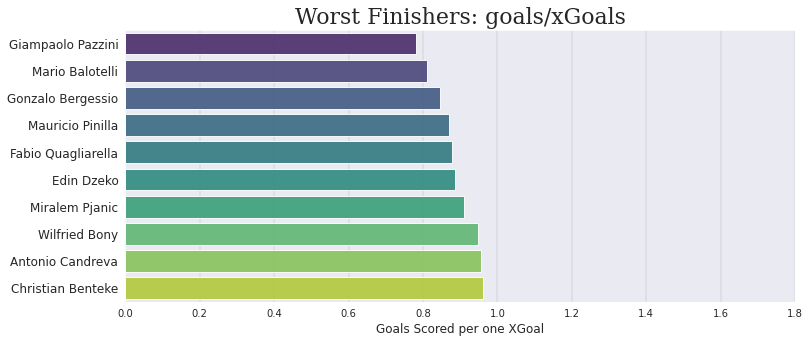

In [51]:
sns.set_style("dark")
fig, ax = plt.subplots(figsize=[12,5])
ax = sns.barplot(x=show['ratio'], y=show['player'], palette='viridis', alpha=0.9)
ax.set_xticks(np.arange(0,1.9,0.2))
ax.set_xlabel(xlabel='Goals Scored per one XGoal', fontsize=12)
ax.set_ylabel(ylabel='')
ax.set_yticklabels(labels=ax.get_yticklabels(), fontsize=12)
plt.title("Worst Finishers: goals/xGoals", fontsize=22, fontfamily='serif')
ax.grid(color='black', linestyle='-', linewidth=0.1, axis='x')
plt.show()

### 4.d) Which players have the most "expected goals"?

In [52]:
show = players[['player', 'trueGoals', 'expectedGoals']].sort_values(['expectedGoals'], ascending=False).head(10)
show.head(10)

,player,trueGoals,expectedGoals
944,Cristiano Ronaldo,198,165.75
2745,Lionel Messi,205,146.21
4779,Zlatan Ibrahimovic,153,119.23
1277,Edinson Cavani,121,113.98
3971,Robert Lewandowski,124,97.04
3817,Pierreemerick Aubameyang,100,86.70
1802,Gonzalo Higuain,118,86.32
451,Antonio Di Natale,76,75.74
1183,Diego Costa,93,72.41
1457,Falcao,80,68.43


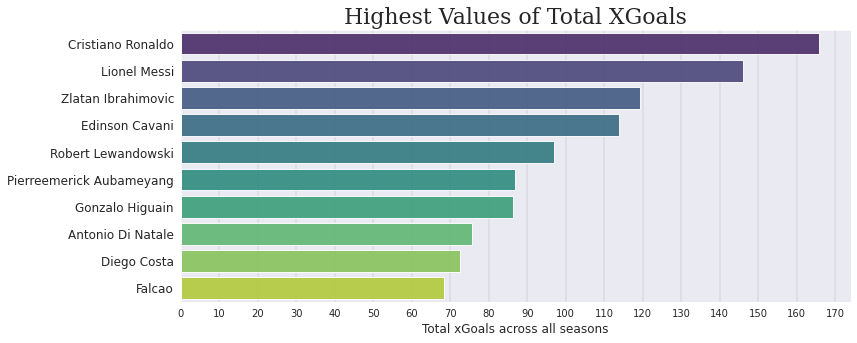

In [53]:
sns.set_style("dark")
fig, ax = plt.subplots(figsize=[12,5])
ax = sns.barplot(x=show['expectedGoals'], y=show['player'], palette='viridis', alpha=0.9)
ax.set_xticks(np.arange(0,180,10))
ax.set_xlabel(xlabel='Total xGoals across all seasons', fontsize=12)
ax.set_ylabel(ylabel='')
ax.set_yticklabels(labels=ax.get_yticklabels(), fontsize=12)
plt.title("Highest Values of Total XGoals", fontsize=22, fontfamily='serif')
ax.grid(color='black', linestyle='-', linewidth=0.1, axis='x')
plt.show()

### 4.e) Which players are the worst at deciding their shots?

By studying the relationship between the players' total expected goals and the total number of shots they attempted, we can determine which players make the worst shooting decisions.We will only include players who have taken a minimum of **100** shots.

In [54]:
# Because event_type is always one in our data, we can use it its sum as the total number of shots each player took.

players.rename(columns={'event_type': 'n_shots'}, inplace=True)

In [55]:
players['xG_per_shot_ratio'] = players['expectedGoals'] / players['n_shots']
show = players[players['n_shots']>100].sort_values(['xG_per_shot_ratio', 'trueGoals'], ascending=False).reset_index(drop=True)
show['rank'] = show.index+1
show[['rank', 'player', 'xG_per_shot_ratio', 'trueGoals', 'expectedGoals', 'difference']].tail(5)

,rank,player,xG_per_shot_ratio,trueGoals,expectedGoals,difference
669,670,Daniel Baier,0.042260,5,7.48,2.48
670,671,Ivan Radovanovic,0.041118,2,6.62,4.62
671,672,Florent Balmont,0.036845,5,6.19,1.19
672,673,Gokhan Inler,0.035622,9,6.59,-2.41
673,674,Tom Huddlestone,0.030463,2,3.29,1.29


We can see that **Tom Huddlestone** appears to be the worst at deciding when to shoot, with an **xG per shot of 0.03**.


At the bottom at the list we find the players who tend to take shots that are likely to be goals, from inside the box or very close range. As expected, here we find mostly strikers and target-men, who tend to play near the opposition's goal. **Diego Milito, Kevin Gameiro, and Carlos Bacca** are among these players. For example, Diego Milito had an average **xGoal per shot of 0.21**, which means that, on average, every shot he took had **more than 20%** chance of being a goal according to our model. In other words, it looks like he only took good/safe shots and did not risk too much.

In [56]:
show = show[['rank', 'player', 'xG_per_shot_ratio', 'trueGoals', 'expectedGoals', 'difference']].head(10)
show.head(10)

,rank,player,xG_per_shot_ratio,trueGoals,expectedGoals,difference
0,1,Diego Milito,0.209058,33,28.85,-4.15
1,2,Kevin Gameiro,0.193663,63,58.68,-4.32
2,3,Ikechukwu Uche,0.192920,21,21.80,0.80
3,4,Carlos Bacca,0.191304,57,44.00,-13.00
4,5,Miku,0.190917,23,20.81,-2.19
5,6,Dario Cvitanich,0.190690,30,22.12,-7.88
6,7,Steven Gerrard,0.189223,22,19.49,-2.51
7,8,Jorge Molina,0.185793,29,30.47,1.47
8,9,Claudio Pizarro,0.183900,47,36.78,-10.22
9,10,Edinson Cavani,0.182953,121,113.98,-7.02


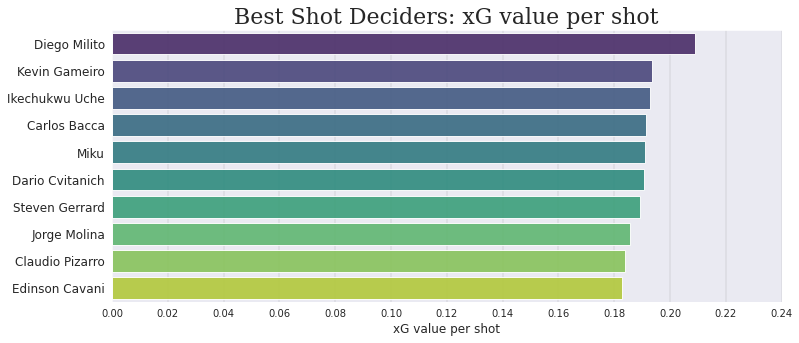

In [57]:
sns.set_style("dark")
fig, ax = plt.subplots(figsize=[12,5])
ax = sns.barplot(x=show['xG_per_shot_ratio'], y=show['player'], palette='viridis', alpha=0.9)
ax.set_xticks(np.arange(0,0.25,0.02))
ax.set_xlabel(xlabel='xG value per shot', fontsize=12)
ax.set_ylabel(ylabel='')
ax.set_yticklabels(labels=ax.get_yticklabels(), fontsize=12)
plt.title("Best Shot Deciders: xG value per shot", fontsize=22, fontfamily='serif')
ax.grid(color='black', linestyle='-', linewidth=0.1, axis='x')
plt.show()

### 4.f) Which players are the best headers?

In [58]:
headers = shots[(shots.event_type==1) & (shots.bodypart==3)]
headers_players = headers.groupby('player').sum().reset_index()
headers_players.rename(columns={'event_type': 'n_headers', 'is_goal': 'trueGoals', 'prediction': 'expectedGoals'}, inplace=True)
headers_players['ratio'] = headers_players['trueGoals'] / headers_players['expectedGoals']
show_headers = headers_players.sort_values(['difference', 'trueGoals']).reset_index(drop=True)
show_headers['rank'] = show_headers.index+1
show_headers[['rank', 'player', 'n_headers', 'trueGoals', 'expectedGoals', 'difference']].head(10)

,rank,player,n_headers,trueGoals,expectedGoals,difference
0,1,Cristiano Ronaldo,159,36,19.996816,-16.003184
1,2,Mario Mandzukic,124,28,14.688200,-13.311800
2,3,Fernando Llorente,141,25,15.941681,-9.058319
3,4,Sloan Privat,86,17,9.919418,-7.080582
4,5,Pierreemerick Aubameyang,59,14,7.308202,-6.691798
5,6,Michail Antonio,32,12,5.608786,-6.391214
6,7,Anthony Modeste,104,17,10.992592,-6.007408
7,8,Zlatan Ibrahimovic,91,17,11.022903,-5.977097
8,9,Gareth Bale,73,14,8.022912,-5.977088
9,10,Daniel Sturridge,20,8,2.274978,-5.725022


We see that **Cristiano Ronaldo** is the best header in the game, when comparing the number of goals he scored with his head with the number of goals he should have scored with our model

### 4.g) Which players are the best at shooting with their left foot?

In [59]:
left_foot = shots[(shots.event_type==1) & (shots.bodypart==2)]
left_foot_players = left_foot.groupby('player').sum().reset_index()
left_foot_players.rename(columns={'event_type': 'n_leftFoot_shots', 'is_goal': 'trueGoals', 'prediction': 'expectedGoals'}, inplace=True)
show_lfoot = left_foot_players.sort_values(['difference', 'trueGoals']).reset_index(drop=True)
show_lfoot['rank'] = show_lfoot.index+1
show_lfoot[['rank', 'player', 'n_leftFoot_shots', 'trueGoals', 'expectedGoals', 'difference']].head(10)

,rank,player,n_leftFoot_shots,trueGoals,expectedGoals,difference
0,1,Lionel Messi,752,167,121.692728,-45.307272
1,2,Antoine Griezmann,345,58,41.495064,-16.504936
2,3,Arjen Robben,296,42,32.168960,-9.831040
3,4,Iago Falque,132,23,13.274948,-9.725052
4,5,Franck Ribery,57,16,6.442227,-9.557773
5,6,Mohamed Salah,129,23,13.891225,-9.108775
6,7,Iago Aspas,180,34,25.364713,-8.635287
7,8,Gareth Bale,195,30,22.029777,-7.970223
8,9,Lukas Podolski,132,21,13.212213,-7.787787
9,10,Zlatan Ibrahimovic,129,25,17.272980,-7.727020


Of course **Lionel Messi** is first on the list. He is the one who scored the most with his left foot when compared to what was expected according to the characteristics surrounding the shot

Now let's see what happens when we look at the **ratio** instead of the **total values**

In [60]:
left_foot_players['ratio'] = left_foot_players['trueGoals'] / left_foot_players['expectedGoals']
show_lfoot = left_foot_players[left_foot_players['trueGoals']>20].sort_values(['ratio', 'trueGoals'], ascending=False).reset_index(drop=True)
show_lfoot['rank'] = show_lfoot.index+1
show_lfoot[['rank', 'player', 'n_leftFoot_shots', 'trueGoals', 'expectedGoals', 'ratio']].head(5)

,rank,player,n_leftFoot_shots,trueGoals,expectedGoals,ratio
0,1,Iago Falque,132,23,13.274948,1.732587
1,2,Mohamed Salah,129,23,13.891225,1.655721
2,3,Lukas Podolski,132,21,13.212213,1.589439
3,4,James Rodriguez,162,23,15.539112,1.480136
4,5,Zlatan Ibrahimovic,129,25,17.272980,1.447347


Some new players like **Mohamed Salah** appear now as very proficient left-foot finishers.

### 4.h) Which players are the best at shooting with their right foot?

In [61]:
right_foot = shots[(shots.event_type==1) & (shots.bodypart==1)]
right_foot_players = right_foot.groupby('player').sum().reset_index()
right_foot_players.rename(columns={'event_type': 'n_rightFoot_shots', 'is_goal': 'trueGoals', 'prediction': 'expectedGoals'}, inplace=True)
show = right_foot_players.sort_values(['difference', 'trueGoals']).reset_index(drop=True)
show['rank'] = show.index+1
show[['rank', 'player', 'n_rightFoot_shots', 'trueGoals', 'expectedGoals', 'difference']].head(5)

,rank,player,n_rightFoot_shots,trueGoals,expectedGoals,difference
0,1,Luis Suarez,289,69,43.187280,-25.812720
1,2,Gonzalo Higuain,362,86,60.848164,-25.151836
2,3,Alexandre Lacazette,270,70,48.132046,-21.867954
3,4,Zlatan Ibrahimovic,554,111,90.935053,-20.064947
4,5,Robert Lewandowski,378,84,65.456162,-18.543838


We see **Luis Suarez** at the top of the list. 

Again we also check the **ratio** instead of the **total values** to see if we have a different scenario.

In [62]:
right_foot_players['ratio'] = right_foot_players['trueGoals'] / right_foot_players['expectedGoals']
show_rfoot = right_foot_players[right_foot_players['trueGoals']>20].sort_values(['ratio', 'trueGoals'], ascending=False).reset_index(drop=True)
show_rfoot['rank'] = show_rfoot.index+1
show_rfoot[['rank', 'player', 'n_rightFoot_shots', 'trueGoals', 'expectedGoals', 'ratio']].head(5)

,rank,player,n_rightFoot_shots,trueGoals,expectedGoals,ratio
0,1,Bas Dost,62,23,13.022098,1.766228
1,2,Franck Ribery,165,24,14.398229,1.666872
2,3,Carlos Tevez,181,33,19.820158,1.664972
3,4,Mario Gotze,170,32,19.885251,1.609233
4,5,Lionel Messi,109,30,18.762947,1.598896


We see **Bas Dost** at the top of the list. 


#### Let's take 4 top players to illustrate this example:**Messi, Cristiano Ronaldo, Zlatan Ibrahimovic, and Robert Lewandowski**

In [63]:
right_foot = right_foot_players[right_foot_players['n_rightFoot_shots']>5]
left_foot = left_foot_players[left_foot_players['n_leftFoot_shots']>5]
headers = headers_players[headers_players['n_headers']>5]
all_players = right_foot[['player']].merge(left_foot, on='player', how='inner').merge(headers, on='player', how='inner')                                                                         
all_players_list = list(all_players['player'].unique())

def compare_players(players_list):
    total = right_foot[right_foot['player'].isin(players_list)][['player', 'ratio']]
    total['bodypart']='Right Foot'
    left_foot['bodypart']='Left Foot'
    headers['bodypart']= 'Header'
    total = pd.concat([total, left_foot[left_foot['player'].isin(players_list)][['player', 'ratio', 'bodypart']], headers[headers['player'].isin(players_list)][['player', 'ratio', 'bodypart']]], axis=0)

    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=[15,8])
    ax = sns.barplot(y=total['ratio'], x=total['player'], hue=total['bodypart'], palette='viridis', alpha=0.9)
    #ax.set_yticks(np.arange(0,2.2,0.2))
    ax.set_ylabel(ylabel='Goals per xG Ratio', fontsize=14)
    ax.set_xlabel(xlabel='')
    ax.set_xticklabels(labels=ax.get_xticklabels(), fontsize=15)
    plt.title("Players Comparison", fontsize=24, fontfamily='serif')
    ax.grid(color='black', linestyle='-', linewidth=0.1, axis='y')
    plt.legend(fontsize=12)
    plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


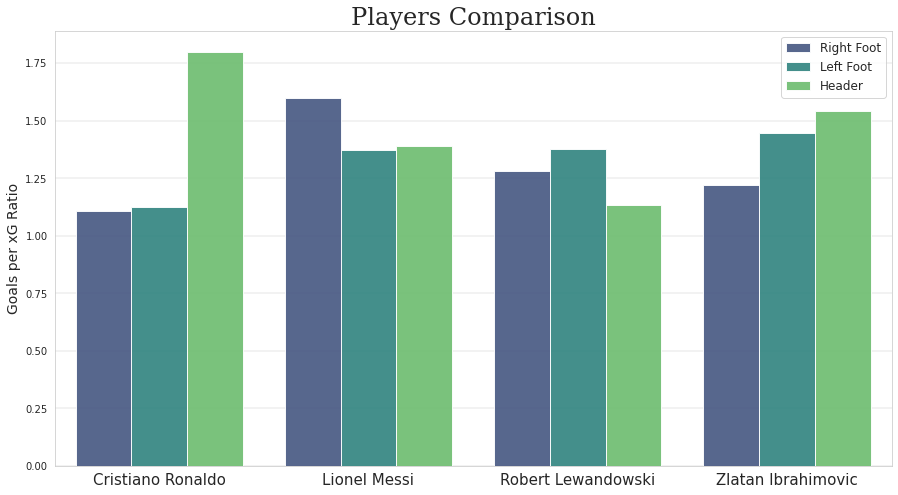

In [64]:
compare_players(players_list = ['Lionel Messi', 'Cristiano Ronaldo', 'Zlatan Ibrahimovic', 'Robert Lewandowski'])

### 4.i) Which are the best outside-the-box shooters?

In [65]:
outside_box = shots[(shots.location==15)]
outbox_players = outside_box.groupby('player').sum().reset_index()
outbox_players.rename(columns={'event_type': 'n_outbox_shots', 'is_goal': 'trueGoals', 'prediction': 'expectedGoals'}, inplace=True)
show = outbox_players.sort_values(['difference', 'trueGoals']).reset_index(drop=True)
show['rank'] = show.index+1
show[['rank', 'player', 'n_outbox_shots', 'trueGoals', 'expectedGoals', 'difference']].head(5)

,rank,player,n_outbox_shots,trueGoals,expectedGoals,difference
0,1,Lionel Messi,304,16,6.396377,-9.603623
1,2,Paul Pogba,226,14,5.989118,-8.010882
2,3,Zlatan Ibrahimovic,261,14,6.781631,-7.218369
3,4,Gonzalo Higuain,127,11,3.862513,-7.137487
4,5,Yaya Toure,128,10,3.378831,-6.621169


We see **Messi, Pogba, and Zlatan** as the ones who scored the most goals from outside the box compared to what they were expected to. In the other end, we find players like **Mario Balotelli** and **Alessandro Diamanti**.


Again let's see the top players from the **trueGoals/xGoals ratio** perspective

In [66]:
outbox_players['ratio'] = outbox_players['trueGoals'] / outbox_players['expectedGoals']
show = outbox_players[outbox_players['n_outbox_shots']>80].sort_values(['ratio', 'trueGoals'], ascending=False).reset_index(drop=True)
show['rank'] = show.index+1
show = show[['rank', 'player', 'n_outbox_shots', 'trueGoals', 'expectedGoals', 'ratio']].head(10)
show.head(5)

,rank,player,n_outbox_shots,trueGoals,expectedGoals,ratio
0,1,James Rodriguez,105,9,2.422206,3.715621
1,2,Alain Traore,86,6,1.831521,3.275965
2,3,Julian Draxler,94,8,2.612772,3.061882
3,4,Alexandre Lacazette,100,9,2.951801,3.048986
4,5,Yaya Toure,128,10,3.378831,2.959603


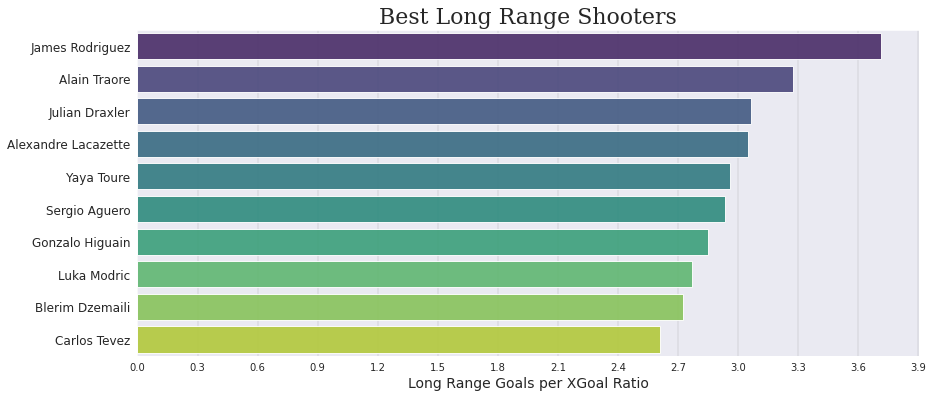

In [67]:
sns.set_style("dark")
fig, ax = plt.subplots(figsize=[14,6])
ax = sns.barplot(x=show['ratio'], y=show['player'], palette='viridis', alpha=0.9)
ax.set_xticks(np.arange(0,4,0.3))
ax.set_xlabel(xlabel='Long Range Goals per XGoal Ratio', fontsize=14)
ax.set_ylabel(ylabel='')
ax.set_yticklabels(labels=ax.get_yticklabels(), fontsize=12)
plt.title("Best Long Range Shooters", fontsize=22, fontfamily='serif')
ax.grid(color='black', linestyle='-', linewidth=0.1, axis='x')
plt.show()

Looks like **James Rodriguez** is the most efficient outside-the-box shooter in the game

### 4.j) Which players make the best/most dangerous passes?


By looking at the player who made the pass/through-ball that came prior to the shot, we can evaluate how much xG a player created from his passing.

In [68]:
passing = shots[shots.assist_method.isin([1,4])]
passing_players = passing.groupby('player2').sum().reset_index()
passing_players.rename(columns={'player2': 'player', 'event_type': 'n_passes', 'is_goal': 'trueGoals_created', 'prediction': 'expectedGoals_created'}, inplace=True)
show = passing_players.sort_values('expectedGoals_created', ascending=False).reset_index(drop=True)
show['rank'] = show.index+1
show[['rank', 'player', 'n_passes', 'trueGoals_created', 'expectedGoals_created']].head(5)

,rank,player,n_passes,trueGoals_created,expectedGoals_created
0,1,Lionel Messi,350,68,51.176955
1,2,Mesut Ozil,343,35,36.690489
2,3,Cesc Fabregas,264,53,36.365714
3,4,Zlatan Ibrahimovic,270,36,36.275964
4,5,Marek Hamsik,370,50,34.948416


This is getting a bit boring, but once again we find **Messi** at the top

We can now instead look at the **mean xG** of these passes to see who are the players who try the most dangerous passing.

In [69]:
show['xG_perpass'] = show['expectedGoals_created'] / show['n_passes']
show = show[show['n_passes']>90].sort_values('xG_perpass', ascending=False).reset_index(drop=True)
show['rank'] = show.index+1
show = show[['rank', 'player', 'n_passes', 'xG_perpass']].head(10)
show.head(5)

,rank,player,n_passes,xG_perpass
0,1,Luis Suarez,185,0.165324
1,2,Gareth Bale,109,0.156334
2,3,Angel Di Maria,211,0.151072
3,4,Lionel Messi,350,0.146220
4,5,Neymar,179,0.144741


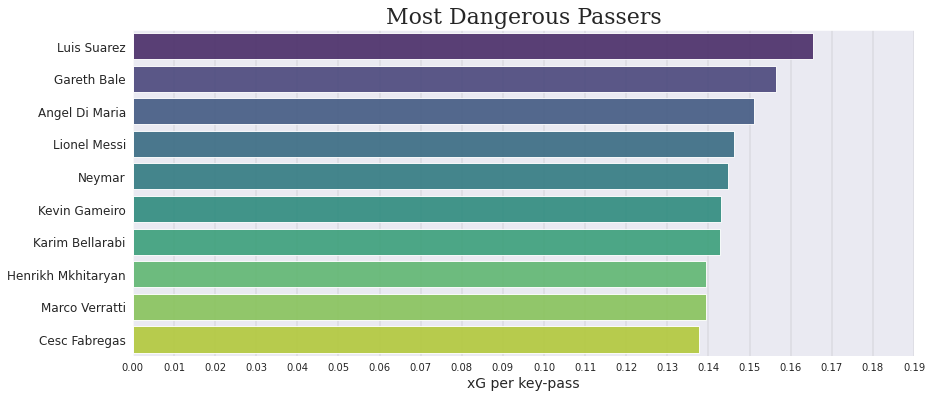

In [70]:
sns.set_style("dark")
fig, ax = plt.subplots(figsize=[14,6])
ax = sns.barplot(x=show['xG_perpass'], y=show['player'], palette='viridis', alpha=0.9)
ax.set_xticks(np.arange(0,0.2,0.01))
ax.set_xlabel(xlabel='xG per key-pass', fontsize=14)
ax.set_ylabel(ylabel='')
ax.set_yticklabels(labels=ax.get_yticklabels(), fontsize=12)
plt.title("Most Dangerous Passers", fontsize=22, fontfamily='serif')
ax.grid(color='black', linestyle='-', linewidth=0.1, axis='x')
plt.show()

We can see **Luis Suarez, Di Maria, and Gareth Bale** among the players who make, on average, the most dangerous passes, as measured by the expected goals value of the subsequent shot.

### 4.k) Which players are the most unlucky when passing the ball?

In [71]:
passing = shots[shots.assist_method.isin([1,4])]
passing_players = passing.groupby('player2').sum().reset_index()
passing_players.rename(columns={'player2': 'player', 'event_type': 'n_passes', 'is_goal': 'trueGoals_created', 'prediction': 'expectedGoals_created'}, inplace=True)
show = passing_players[passing_players['n_passes']>50].sort_values('difference', ascending=False).reset_index(drop=True)
show['rank'] = show.index+1
show[['rank', 'player', 'n_passes', 'trueGoals_created', 'expectedGoals_created', 'difference']].head(10)

,rank,player,n_passes,trueGoals_created,expectedGoals_created,difference
0,1,Joan Verdu,134,7,14.579980,7.579980
1,2,Xabi Prieto,152,6,13.206584,7.206584
2,3,Philippe Coutinho,177,13,19.894448,6.894448
3,4,Luca Cigarini,164,6,12.817758,6.817758
4,5,Alejandro Gomez,137,5,11.766530,6.766530
5,6,Antonio Di Natale,136,7,13.249445,6.249445
6,7,Victor Ibarbo,116,6,12.158410,6.158410
7,8,Mariano,100,2,7.774624,5.774624
8,9,Nolito,179,18,23.723433,5.723433
9,10,Ezequiel Schelotto,65,2,7.457199,5.457199


In [72]:
show[['rank', 'player', 'n_passes', 'trueGoals_created', 'expectedGoals_created', 'difference']].tail(5)

,rank,player,n_passes,trueGoals_created,expectedGoals_created,difference
686,687,Marek Hamsik,370,50,34.948416,-15.051584
687,688,Cristiano Ronaldo,222,45,29.226213,-15.773787
688,689,Karim Benzema,214,40,23.383733,-16.616267
689,690,Cesc Fabregas,264,53,36.365714,-16.634286
690,691,Lionel Messi,350,68,51.176955,-16.823045


At the top of the list we also see some famous unlucky players though, such as **Philippe Coutinho** , who should have seen higher numbers in their "Assists" stats according to the chances they created for the team.